In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --quiet tensorflow-text
!pip install --quiet tokenizers
import numpy as np 
import pandas as pd 
import pickle
import os 
import re
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import Model,Input,layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *

import tensorflow_hub as hub 
import tokenizers
from tokenizers import BertWordPieceTokenizer
import tensorflow_text as text 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import platform
import sklearn 
from sklearn.metrics import f1_score,classification_report,confusion_matrix
# from data_loader import load_sentences,list_maker
# from helper_functions import tag_encoder
# from token_functions import token_aligner,encoder,tag_encoder_2,padder

# from model import ner_model
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_path = 'drive/MyDrive/Colab Notebooks/datasets/conn2003/train.txt'
test_path = 'drive/MyDrive/Colab Notebooks/datasets/conn2003/test.txt'
validation_path = 'drive/MyDrive/Colab Notebooks/datasets/conn2003/valid.txt'

saving_path = './'

input_len =128
epochs = 10
batch = 400

In [4]:
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_url = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/2'

bert_layer = hub.KerasLayer(bert_url, trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy().decode("utf-8")
tokenizer = BertWordPieceTokenizer(vocab=vocab_file, lowercase=False)


In [5]:
def load_sentences(filepath):

    final = []
    sentences = []

    with open(filepath, 'r') as f:
        
        for line in f.readlines():
            
            if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                l = line.split(' ')
                sentences.append((l[0], l[3].strip('\n')))
    
    return final

def list_maker(data_set,col):
    v2 = []

    for i in data_set:
        v1 = []

        for j in i:
            v1.append(j[col])
        x = ' '.join(v1)
        x = re.sub('  ',' ',x)
        x = re.sub(r"\s+$", "", x, flags=re.UNICODE)
        x = re.sub("^\s+|\s+$", "", x, flags=re.UNICODE)
        v2.append(x)

        # v2.append(' '.join(v1))

    return v2

def tag_encoder(tags,tags_2enc):
    '''
    encoding tags using tag corpus(enc_2tags)
    '''

    encoded_tags = []

    for i in tags:
        t1 = []

        for j in i.split():

            t1.append(tags_2enc[str(j)])
        encoded_tags.append(t1)

    return encoded_tags

def tag_encoder_2(tags,tags_2enc):
    '''
    encoding tags using tag corpus(enc_2tags)
    '''

    encoded_tags = []

    for i in tags:
        t1 = []

        for j in i:

            t1.append(tags_2enc[str(j)])
        encoded_tags.append(t1)

    return encoded_tags
	
class str_maker :

  def __init__(self, data):
    self.data = data 

  def splitter(self):
    str_data = []
    for i in self.data:
      str_data.append(' '.join(i.split()))

    return str_data

def token_aligner(sentences_train,tags_train):
    var2 = []
    for j in range(len(sentences_train)):
        encoded_sentence = tokenizer.encode(sentences_train[j])
        tags = tags_train[j].split(' ')
        counter = 0
        var1 = []
        for i in range(1, len(encoded_sentence.offsets)- 1):
            x = encoded_sentence.offsets[i][0]
            y = encoded_sentence.offsets[i-1][1]

            if x!=y :
                counter +=1
                var1.append(tags[counter])
            if x == y:
                var1.append(tags[counter]) 
        var2.append(var1)
    
    return var2

def encoder(x):
    tokenizer = BertWordPieceTokenizer(vocab=vocab_file, lowercase=True)
    ids = []
    type_ids = []
    attention_mask = []
    ids_len = []
    tokens= []
    for i in range(len(x)):
        var1 = tokenizer.encode(x[i])
        ids.append(var1.ids)
        type_ids.append(var1.type_ids)
        attention_mask.append(var1.attention_mask)
        tokens = var1.tokens
        ids_len.append(len(var1.ids))
    return ids, type_ids, attention_mask,tokens,ids_len

def padder(x,pad_len):
    padded_var = pad_sequences(
    x,
    maxlen=pad_len,
    dtype='int32',
    padding='post',
    truncating='post',
    value=0.0
    )
    return padded_var

In [6]:
train_set  = load_sentences(train_path)
test_set  = load_sentences(test_path)
validation_set  = load_sentences(validation_path)

print('train_set_length :',len(train_set))
print('test_set_length :',len(test_set))
print('validation_set_length :',len(validation_set))

sentences_train = list_maker(train_set, 0)
tags_train = list_maker(train_set, 1)

sentences_test = list_maker(test_set, 0)
tags_test = list_maker(test_set, 1)

sentences_validation = list_maker(validation_set, 0)
tags_validation = list_maker(validation_set, 1)

j_tags = ' '.join(tags_train)
unique_tags = np.unique(j_tags.split())

num_tags = len(unique_tags) ### number of unique tags
enc_2tags = {i:j for i,j in enumerate(unique_tags)}
tags_2enc = {j:i for i,j in enumerate(unique_tags)}

aligned_tags_train = token_aligner(sentences_train,tags_train)
aligned_tags_val = token_aligner(sentences_validation,tags_validation)

train_ids, train_type_ids, train_attention_mask,train_tokens,ids_len = encoder(sentences_train)
encoded_tags_train = tag_encoder_2(aligned_tags_train,tags_2enc)

val_ids, val_type_ids, val_attention_mask,validation_tokens,ids_len = encoder(sentences_validation)
encoded_tags_val = tag_encoder_2(aligned_tags_val,tags_2enc)

print('number of unique tags :', num_tags)
print('unique tags:', unique_tags)

train_set_length : 14041
test_set_length : 3453
validation_set_length : 3250
number of unique tags : 9
unique tags: ['B-LOC' 'B-MISC' 'B-ORG' 'B-PER' 'I-LOC' 'I-MISC' 'I-ORG' 'I-PER' 'O']


In [7]:
a_file = open(saving_path+"enc_2tags.pkl", "wb")
pickle.dump(enc_2tags, a_file)
a_file.close()

a_file = open(saving_path+"tags_2enc.pkl", "wb")
pickle.dump(tags_2enc, a_file)
a_file.close()


a_file = open(saving_path+"tags_2enc.pkl", "rb")
tags_2enc = pickle.load(a_file)
print(tags_2enc)

a_file = open(saving_path+"enc_2tags.pkl", "rb")
enc_2tags = pickle.load(a_file)
print(enc_2tags)

{'B-LOC': 0, 'B-MISC': 1, 'B-ORG': 2, 'B-PER': 3, 'I-LOC': 4, 'I-MISC': 5, 'I-ORG': 6, 'I-PER': 7, 'O': 8}
{0: 'B-LOC', 1: 'B-MISC', 2: 'B-ORG', 3: 'B-PER', 4: 'I-LOC', 5: 'I-MISC', 6: 'I-ORG', 7: 'I-PER', 8: 'O'}


In [8]:
pad_ids_train = padder(train_ids,input_len)
pad_type_ids_train = padder(train_type_ids,input_len)
pad_attention_mask_train = padder(train_attention_mask,input_len)
pad_tags_train = padder(encoded_tags_train, input_len)


pad_ids_val = padder(val_ids,input_len)
pad_type_ids_val = padder(val_type_ids,input_len)
pad_attention_mask_val = padder(val_attention_mask,input_len)
pad_tags_val = padder(encoded_tags_val, input_len)

preprocessor = hub.KerasLayer(encoder_url)
encoder = hub.KerasLayer(bert_url,trainable=True)

In [9]:
print('number of unique tags:',num_tags)

number of unique tags: 9


In [10]:
def ner_model(num_tags):
    encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
    bert_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/2"

    encoder = hub.KerasLayer(bert_url,trainable=True)
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    encoder_inputs = preprocessor(text_input)
    outputs = encoder(encoder_inputs)
    sequence_output = outputs["sequence_output"]
    sequence_output = Dropout(0.3)(sequence_output)
    final_layer = Dense(num_tags, activation = 'softmax')(sequence_output)
    return Model(inputs = text_input, outputs = final_layer)

bert_ner_model = ner_model(num_tags)
bert_ner_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

# bert_ner_model.fit(
#     np.array(sentences_train),
#     pad_tags_train,
#     epochs = epochs,
#     # batch_size = batch,
#     )

# bert_ner_model.save_weights('drive/MyDrive/Colab Notebooks/trained_models/bert_ner_model/model_weights/bert_ner_weights.h5')
bert_ner_model.load_weights('drive/MyDrive/Colab Notebooks/trained_models/bert_ner_model/model_weights/bert_ner_weights.h5')
p = bert_ner_model.predict(np.array(sentences_validation))

102/102 [==============================] - 8s 70ms/step


In [11]:
v2= []
for i in range(len(encoded_tags_val)):
    word_vector_pred = p[i]
    z = word_vector_pred[0:len(encoded_tags_val[i])]
    v1 = []
    for j in z:
        v1.append(np.argmax(j))
    v2.append(v1)

In [12]:
tags_validation_logits = [enc_2tags[i] for i in np.concatenate(encoded_tags_val)]
tags_validation_pred = [enc_2tags[i] for i in np.concatenate(v2)]

In [13]:
print('F1 score:',f1_score((np.concatenate(encoded_tags_val)), (np.concatenate(v2)), average='micro'))

conf_mat=confusion_matrix(tags_validation_logits,tags_validation_pred,
                            labels=['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'])
print(conf_mat)

F1 score: 0.917871611886156
[[ 1612    41    26    25    18     0     6     2   501]
 [   22   655    23     9     4     4     1     0   331]
 [   49    42   919    31     2     2    31     4   350]
 [   63    15    77  1266     1     0     2   124   425]
 [    9     0     0     1   182     1     4     4    63]
 [    3    47     1     3     6   149     2     5   151]
 [   11     5    40     4     9     8   396     9   312]
 [   47     0     0   114    11     0    22   824   340]
 [  525   132    93   204    33    38   152   205 48145]]


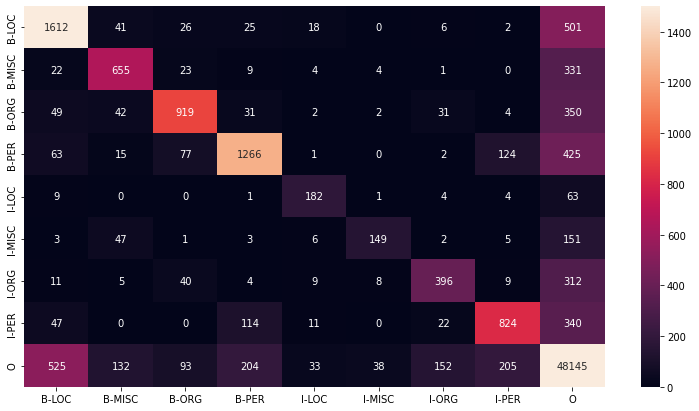

In [14]:

fig, ax = plt.subplots(figsize=(13,7)) 
labels=['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']
sns.heatmap(conf_mat, annot=True,fmt='.5g',vmin=0, vmax=1500,
                            xticklabels=labels, yticklabels=labels);

In [15]:
print(classification_report(np.concatenate(encoded_tags_val), np.concatenate(v2),
                            target_names = ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']
                            ))

              precision    recall  f1-score   support

       B-LOC       0.69      0.72      0.71      2231
      B-MISC       0.70      0.62      0.66      1049
       B-ORG       0.78      0.64      0.70      1430
       B-PER       0.76      0.64      0.70      1973
       I-LOC       0.68      0.69      0.69       264
      I-MISC       0.74      0.41      0.52       367
       I-ORG       0.64      0.50      0.56       794
       I-PER       0.70      0.61      0.65      1358
           O       0.95      0.97      0.96     49527

    accuracy                           0.92     58993
   macro avg       0.74      0.64      0.68     58993
weighted avg       0.91      0.92      0.91     58993



In [16]:
num = 0

print('test_sentece :',sentences_validation[num])
print('test_tags :',tags_validation[0])
# print(len(encoded_tags_val[num]))
toks = []
for j,i in enumerate(np.array(tf.math.top_k(p[num][0:len(encoded_tags_val[num])],k=1)[1])):
    # print(j,i)
    toks.append(enc_2tags[int(i)])
print('pred_tags :',' '.join(toks))

test_sentece : CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTER INNINGS VICTORY .
test_tags : O O B-ORG O O O O O O O O
pred_tags : O O B-ORG O O O O O O O O
